# Projeto Módulo 6 - ESTATÍSTICA

## Sobre o Projeto

O projeto se baseia nos dados públicos da Despesa pela Cota para Exercício da Atividade Parlamentar fornecidos pela Câmara dos Deputados.<br><br>
Os arquivos incluem o gasto de cada deputado de 2008 até o ano atual (2024).<br><br>
A fonte dos dados pode ser encontrada [aqui](https://dadosabertos.camara.leg.br/swagger/api.html#staticfile).

### Sobre o arquivo
Para melhor compreensão do conteúdo abordado, lista-se aqui os significados de alguns dos campos abordados durante a análise:
* **txNomeParlamentar** <br>
Nome adotado pelo parlamentar no início de seu mandato na legislatura. O campo também pode trazer o título identificador de uma liderança partidária, à qual líderes e vice-líderes podem direcionar parte de suas próprias cotas individuais.
* **ideCadastro**<br>
Identificador numérico exclusivo de cada parlamentar da Câmara dos Deputados.
* **sgUF**<br>
Sigla da unidade da federação (estados e Distrito Federal) por qual o respectivo parlamentar foi eleito.
* **sgPartido**<br>
Sigla do partido ao qual o parlamentar é/era filiado.
* **codLegislatura**<br>
Número identificador da legislatura na qual ocorreu a despesa.
* **numSubCota**<br>
Código numérico de uma categoria de despesa à qual o registro seja pertinente.
* **txtDescricao**<br>
Título da categoria de despesa à qual seja pertinente o registro — a mesma referida pelo campo numSubCota.
* **vlrDocumento**<br>
Valor de face do documento comprobatório da despesa. Alguns tipos de despesa podem ter registros com valores negativos: nos de passagens aéreas, por exemplo, isso ocorre quando são emitidos bilhetes de compensação pela não-utilização de uma passagem.
* **vlrGlosa**<br>
Valor retido, isto é, não coberto pela CEAP, por qualquer razão (impedimento legal, insuficiência de comprovação, etc).
* **vlrLiquido**<br>
Valor da despesa efetivamente debitado da Cota Parlamentar, correspondente ao vlrDocumento menos o vlrGlosa. Em despesas de Telefonia, é possível que este valor seja registrado como 0, significando que a despesa foi coberta pela franquia do contrato.
<br>

*Informações adicionais sobre os campos podem ser encontradas [aqui](https://dadosabertos.camara.leg.br/howtouse/2023-12-26-dados-ceap.html)*

### Equipe
César Augusto <br>
Eduardo Carvalho<br>
Iago Mansur<br>
Leonardo Henrrique<br>
Myrna Martinelli<br>
Ruan Faria

## Importação dos arquivos e Análise exploratória

**Importando as bibliotecas**

In [1]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp

import matplotlib.ticker as ticker
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats import kstest, norm

**Importando os dados**

In [2]:
diretorio_principal = os.getcwd()
subdiretorio_dados = os.path.join(diretorio_principal, "Dados")

# Criar o diretório se não existir
os.makedirs(subdiretorio_dados, exist_ok=True)

In [3]:
anos = range(2008, 2024)
formato = "csv"
url_base = "http://www.camara.leg.br/cotas/"

for ano in anos:
    download = requests.get(url_base + f"Ano-{ano}.{formato}.zip")
    caminho_zip = os.path.join(subdiretorio_dados, f"Ano-{ano}.{formato}.zip")

    with open(caminho_zip, "wb") as file:
        file.write(download.content)

    # Extrair o conteúdo do arquivo ZIP
    with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
        zip_ref.extractall(subdiretorio_dados)

    # # Remover o arquivo ZIP após extração (opcional)
    # os.remove(caminho_zip)

In [3]:
# Voltar ao diretório principal
os.chdir(diretorio_principal)

# Criar um DataFrame com os dados extraídos
despesas_totais = []

for arquivo_csv in os.listdir(subdiretorio_dados):
    if arquivo_csv.endswith('.csv') and not arquivo_csv.startswith("."):
        caminho_csv = os.path.join(subdiretorio_dados, arquivo_csv)
        despesas = pd.read_csv(caminho_csv, sep=";", encoding='UTF-8', low_memory=False)
        despesas_totais.append(despesas)

# Concatenar todos os DataFrames em um único DataFrame
despesas_completo = pd.concat(despesas_totais, ignore_index=True)

In [4]:
despesas_completo.head()

,txNomeParlamentar,cpf,ideCadastro,nuCarteiraParlamentar,nuLegislatura,sgUF,sgPartido,codLegislatura,numSubCota,txtDescricao,...,numParcela,txtPassageiro,txtTrecho,numLote,numRessarcimento,datPagamentoRestituicao,vlrRestituicao,nuDeputadoId,ideDocumento,urlDocumento
0,JOSEPH BANDEIRA,7.251603e+09,4929.0,565.0,2007,BA,PT,53,2,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",...,0,NaN,NaN,405260,NaN,NaN,NaN,1970,1612380,NaN
1,JOSEPH BANDEIRA,7.251603e+09,4929.0,565.0,2007,BA,PT,53,2,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",...,0,NaN,NaN,387830,NaN,NaN,NaN,1970,1561354,NaN
2,SILVIO COSTA,1.048139e+10,4930.0,160.0,2007,PE,PTB,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,1973,0,NaN
3,ALDO REBELO,1.641215e+10,73428.0,331.0,2007,SP,PCdoB,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,764,0,NaN
4,ANTONIO CARLOS PANNUNZIO,1.895236e+10,73431.0,334.0,2007,SP,PSDB,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,961,0,NaN


In [5]:
despesas_completo.shape

(4666841, 32)

In [6]:
# Listar colunas
despesas_completo.columns

Index(['txNomeParlamentar', 'cpf', 'ideCadastro', 'nuCarteiraParlamentar',
       'nuLegislatura', 'sgUF', 'sgPartido', 'codLegislatura', 'numSubCota',
       'txtDescricao', 'numEspecificacaoSubCota', 'txtDescricaoEspecificacao',
       'txtFornecedor', 'txtCNPJCPF', 'txtNumero', 'indTipoDocumento',
       'datEmissao', 'vlrDocumento', 'vlrGlosa', 'vlrLiquido', 'numMes',
       'numAno', 'numParcela', 'txtPassageiro', 'txtTrecho', 'numLote',
       'numRessarcimento', 'datPagamentoRestituicao', 'vlrRestituicao',
       'nuDeputadoId', 'ideDocumento', 'urlDocumento'],
      dtype='object')

In [6]:
#Total de parlamentares por partido
cotas_por_partido = despesas_completo.groupby(['sgPartido','txNomeParlamentar'],as_index=False).size()

total_parlamentares = cotas_por_partido.groupby('sgPartido').size()
total_parlamentares.rename_axis(None, inplace=True)

print(f"""Partidos com mais parlamentares: \n{total_parlamentares.nlargest(10)}\n
Partidos com menos parlamentares: \n{total_parlamentares.nsmallest(10)}""")

Partidos com mais parlamentares: 
PT       212
PSDB     152
PMDB     146
PSD      140
PL       128
PP       125
MDB      117
DEM      108
UNIÃO     99
PSB       98
dtype: int64

Partidos com menos parlamentares: 
PEN         1
PPL         1
PSDC        1
PRTB        2
PRP         3
S.PART.     3
PTC         4
PATRI       5
PATRIOTA    5
PMN         5
dtype: int64


In [7]:
#Total de apontamentos por partido

# Group by 'sgPartido' e conta quantas vezes aparece 'txNomeParlamentar' em cada partido
part_total = despesas_completo.groupby('sgPartido')['txNomeParlamentar'].count()
part_total.rename_axis(None, inplace=True)

print(f"""Total de partidos: {part_total.count()}\n
Partidos com mais apontamentos: \n{part_total.nlargest(10)}\n
Partidos com menos apontamentos: \n{part_total.nsmallest(10)}""")

Total de partidos: 43

Partidos com mais apontamentos: 
PT      716019
PSDB    407567
PMDB    313274
PSD     301334
PP      273132
PR      252306
DEM     247692
PSB     242782
MDB     230506
PP**    173469
Name: txNomeParlamentar, dtype: int64

Partidos com menos apontamentos: 
PSDC         236
PRTB         268
PEN          729
PRD         2156
PPL         2227
PTC         3743
PRP         4039
S.PART.     6241
PATRIOTA    7620
PMN         8115
Name: txNomeParlamentar, dtype: int64


In [8]:
#Somando o 'vlrLiquido' por partido 

# Group by 'sgPartido' e soma o valor contido em 'vlrLiquido' por partido
vlrLiquido_por_partido = despesas_completo.groupby('sgPartido')['vlrLiquido'].sum()
vlrLiquido_por_partido.rename_axis(None, inplace=True)

print(f"""Partidos com maior Valor Líquido gasto: \n{vlrLiquido_por_partido.nlargest(10)}\n
Partidos com menor Valor Líquido gasto: \n{vlrLiquido_por_partido.nsmallest(10)}""")

Partidos com maior Valor Líquido gasto: 
PT      3.924607e+08
PSDB    2.128687e+08
PSD     2.121865e+08
PP      2.053853e+08
MDB     1.731129e+08
PL      1.560287e+08
PMDB    1.518192e+08
DEM     1.381063e+08
PR      1.355463e+08
PSB     1.351729e+08
Name: vlrLiquido, dtype: float64

Partidos com menor Valor Líquido gasto: 
PSDC        125088.44
PRTB        167589.80
PEN         270935.47
PTC        1770488.02
PPL        1871243.73
PRD        2241929.66
S.PART.    2297041.30
PRP        3889258.26
NOVO       3912222.55
PMN        4944567.22
Name: vlrLiquido, dtype: float64


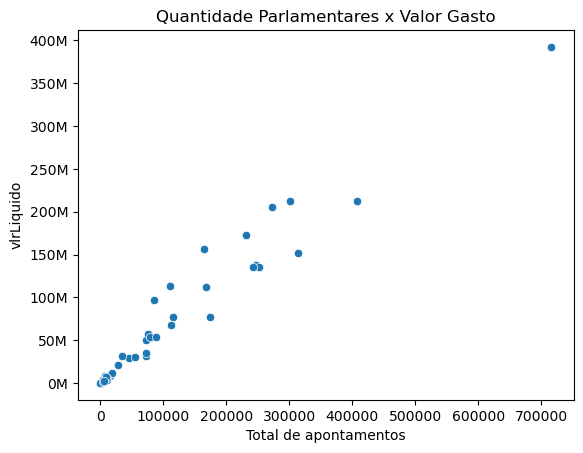

In [9]:
ax = sns.scatterplot(x=part_total, y=vlrLiquido_por_partido)
ax.set_title('Quantidade Parlamentares x Valor Gasto')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x*1e-6) + 'M'))
plt.xlabel('Total de apontamentos')
plt.show;

In [10]:
#vlrLiquido por quantidade de parlamentar por patido 

vlrLiquido_por_parlamentar_por_pat = vlrLiquido_por_partido / part_total
vlrLiquido_por_parlamentar_por_pat.rename_axis(None, inplace=True)

print(f"""Top 10 Gasto médio por parlamentar: \n{vlrLiquido_por_parlamentar_por_pat.nlargest(10)}\n
Bottom 10 Gasto médio por parlamentar: \n{vlrLiquido_por_parlamentar_por_pat.nsmallest(10)}""")

Top 10 Gasto médio por parlamentar: 
REPUBLICANOS     1129.165180
PATRIOTA         1083.767993
PRD              1039.856058
UNIÃO            1025.930801
PRP               962.926036
PL                947.207172
SOLIDARIEDADE     909.096826
PPL               840.253134
AVANTE            763.230349
PP                751.963598
dtype: float64

Bottom 10 Gasto médio por parlamentar: 
S.PART.    368.056610
PEN        371.653594
NOVO       383.852291
PPS        437.154794
PP**       441.944646
PTC        473.013096
PMDB       484.621248
PV         488.770218
PTdoB      497.485485
PSDB       522.291322
dtype: float64


## Selecionando Dados de Estudo

A variedade de colunas distintas, bem como a grande quantidade de dados disponíveis possibilitam diversas análises diferentes. <br>A fim de reduzir o escopo e trazer uma análise mais aprofundada e que agregasse mais valor, foi selecionado um número reduzido de colunas. <br>

In [71]:
# Selecionar colunas
dataset_2 = despesas_completo.loc[:,['sgUF', 'sgPartido', 'txtDescricao', 'datEmissao', 'vlrLiquido' ]]

In [72]:
# Visualizar dados de estudo
dataset_2.head()

,sgUF,sgPartido,txtDescricao,datEmissao,vlrLiquido
0,BA,PT,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",2009-06-18T00:00:00,3800.00
1,BA,PT,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",2009-03-30T00:00:00,6000.00
2,PE,PTB,TELEFONIA,2008-12-01T00:00:00,80.01
3,SP,PCdoB,TELEFONIA,2008-12-01T00:00:00,372.55
4,SP,PSDB,TELEFONIA,2008-03-10T00:00:00,38.48


In [14]:
dataset_2.shape

(4666874, 5)

In [15]:
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4666874 entries, 0 to 4666873
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   sgUF          object 
 1   sgPartido     object 
 2   txtDescricao  object 
 3   datEmissao    object 
 4   vlrLiquido    float64
dtypes: float64(1), object(4)
memory usage: 178.0+ MB


### Convertendo os dados referentes à data

In [73]:
dataset_2['datEmissao'] = pd.to_datetime(dataset_2['datEmissao'], errors='coerce')

### Tratamento de dados duplicados e faltantes

In [74]:
dataset_2 = dataset_2.drop_duplicates(keep="first")

In [75]:
dataset_2 = dataset_2.dropna()

In [76]:
dataset_2.shape

(4133926, 5)

### Visualizando dados de estudo

In [17]:
dataset_2[['sgUF', 'sgPartido', 'txtDescricao']].describe()

,sgUF,sgPartido,txtDescricao
count,4133926,4133926,4133926
unique,27,43,24
top,SP,PT,COMBUSTÍVEIS E LUBRIFICANTES.
freq,635110,635984,960118


## Especificando os atributos de interesse

A análise foi desenvolvida com base nos gastos em *Combustíveis e Lubrificantes*, que representam 23% da quantidade total.

In [25]:
dataset_2 = dataset_2[dataset_2['txtDescricao'] == 'COMBUSTÍVEIS E LUBRIFICANTES.']

In [26]:
dataset_2.shape

(960118, 5)

In [27]:
dataset_2['vlrLiquido'].describe()

count    960118.000000
mean        254.998752
std         609.302421
min       -2778.900000
25%          91.030000
50%         130.000000
75%         200.000000
max       13013.500000
Name: vlrLiquido, dtype: float64

### Verificando o tipo de distribuição

In [24]:
#Testando para distribuição normal
coluna_vlrLiquido = dataset_2['vlrLiquido']

coluna_vlrLiquido = np.random.normal(loc=0, scale=1, size=1000)

#Realiza teste de kolmogorov-Smirnov
statistic, p_value = kstest(coluna_vlrLiquido, 'norm')

# Compara o p-valor com nível de significância
alpha = 0.05

if p_value > alpha:
    print("Os dados seguem uma distribuição normal (hipótese nula não pode ser rejeitada)")
else:
    print("Os dados não seguem uma distribuição normal (hipótese nula rejeitada)")

Os dados seguem uma distribuição normal (hipótese nula não pode ser rejeitada)


### Medidas de tendência central

In [25]:
# Média geral
dataset_2['vlrLiquido'].mean()

254.99565947027415

In [28]:
media_por_estado = dataset_2.groupby('sgUF')['vlrLiquido'].mean()

media_por_estado_ord = media_por_estado.sort_values(ascending=False)

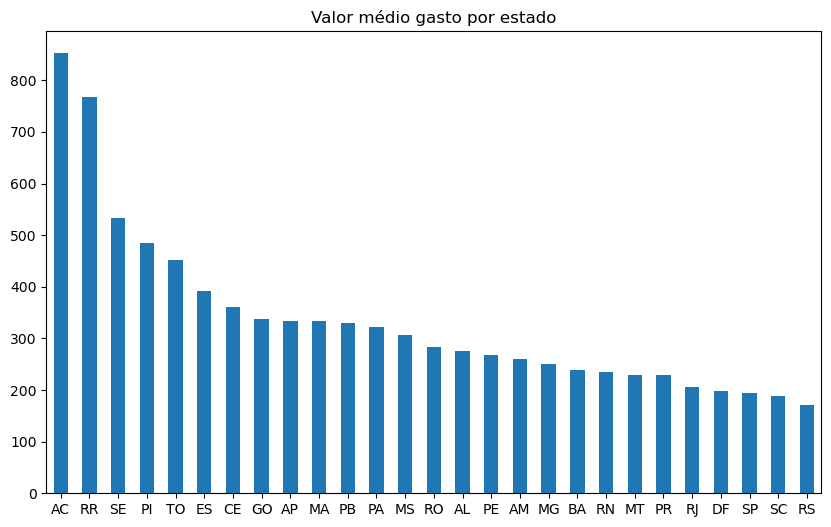

In [29]:
media_por_estado_ord.plot(kind='bar', figsize=(10, 6), title='Valor médio gasto por estado')
plt.xticks(rotation=0)
plt.xlabel('')
plt.show();

In [30]:
# Média por partido
media_por_partido = dataset_2.groupby('sgPartido')['vlrLiquido'].mean()
media_por_partido.rename_axis(None, inplace=True)

print(f"""Top 10 Gasto médio por partido: \n{media_por_partido.nlargest(10)}\n
Bottom 10 Gasto médio por partido: \n{media_por_partido.nsmallest(10)}""")

Top 10 Gasto médio por partido: 
PSDC             1207.098750
PTC               510.253811
PRD               404.194912
PATRIOTA          402.851081
PROS              320.489950
PTB               319.168633
SOLIDARIEDADE     313.222975
PP                298.173202
PHS               295.149717
UNIÃO             294.628145
Name: vlrLiquido, dtype: float64

Bottom 10 Gasto médio por partido: 
PRTB         134.037927
PPS          154.424239
PPL          159.508625
PEN          169.772178
NOVO         180.055686
CIDADANIA    180.300654
PATRI        187.615964
PSOL         195.810878
SDD          200.503057
PV           204.102841
Name: vlrLiquido, dtype: float64


In [31]:
media_por_partido_por_palamentar = vlrLiquido_por_parlamentar_por_pat.mean()
print('Valor líquido médio por partido_por_palamentar: ',media_por_partido_por_palamentar)

Valor líquido médio por partido_por_palamentar:  664.830353945981


In [32]:
# Moda geral
dataset_2['vlrLiquido'].mode()

0    100.0
Name: vlrLiquido, dtype: float64

In [33]:
# Moda por partido
moda_por_partido= dataset_2.groupby('sgPartido')['vlrLiquido'].apply(lambda x: x.mode().iloc[0])

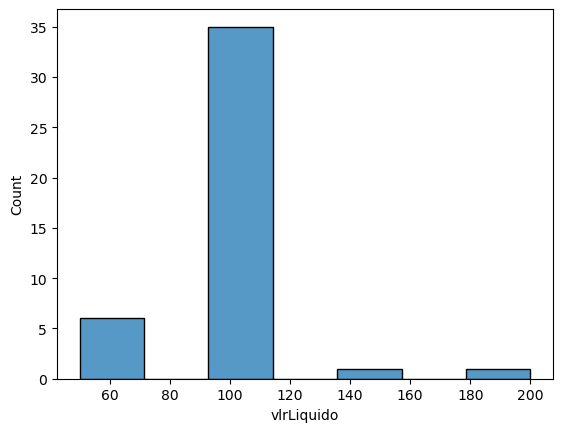

In [34]:
sns.histplot(moda_por_partido);

In [35]:
#Moda do vlrLiquido por partido_por_palamentar

moda_por_partido_por_palamentar = vlrLiquido_por_parlamentar_por_pat.mode()

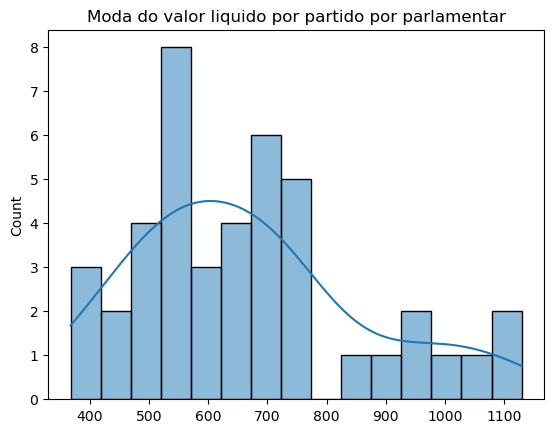

In [36]:
ax = sns.histplot(moda_por_partido_por_palamentar, bins=15, kde=True);
ax.set_title('Moda do valor liquido por partido por parlamentar');

In [35]:
# Mediana geral
dataset_2['vlrLiquido'].median()

130.0

In [36]:
# Mediana por estado
mediana_por_estado = dataset_2.groupby('sgUF')['vlrLiquido'].median()

mediana_por_estado_ord = mediana_por_estado.sort_values(ascending=False)
mediana_por_estado_ord.rename_axis(None, inplace=True)

print(mediana_por_estado_ord)

AC    191.600
TO    181.020
RR    171.680
SE    168.145
RO    151.360
PI    150.000
ES    148.715
CE    148.020
PB    145.000
DF    143.200
AL    140.050
MG    139.690
GO    138.000
MT    137.425
PR    135.080
MS    134.010
PE    133.600
RS    132.020
RJ    130.000
SC    129.000
MA    125.000
BA    120.010
RN    120.000
SP    109.010
AM    100.050
AP    100.000
PA    100.000
Name: vlrLiquido, dtype: float64


In [38]:
# Mediana por partido
mediana_por_partido = dataset_2.groupby('sgPartido')['vlrLiquido'].median()
mediana_por_partido.rename_axis(None, inplace=True)

print(f"""Top 10 mediana por partido: \n{mediana_por_partido.nlargest(10)}\n
Bottom 10 mediana por partido: \n{mediana_por_partido.nsmallest(10)}""")

Top 10 mediana por partido: 
PRD             229.250
PATRIOTA        226.310
UNIÃO           200.580
PL              200.000
REPUBLICANOS    200.000
PP              175.380
MDB             172.140
AVANTE          170.635
NOVO            165.225
CIDADANIA       161.205
Name: vlrLiquido, dtype: float64

Bottom 10 mediana por partido: 
PTdoB     70.000
PTC       74.010
PATRI    100.000
PMN      100.000
PPS      100.000
PV       100.000
SDD      100.000
PMDB     100.010
PRTB     100.015
PP**     103.300
Name: vlrLiquido, dtype: float64


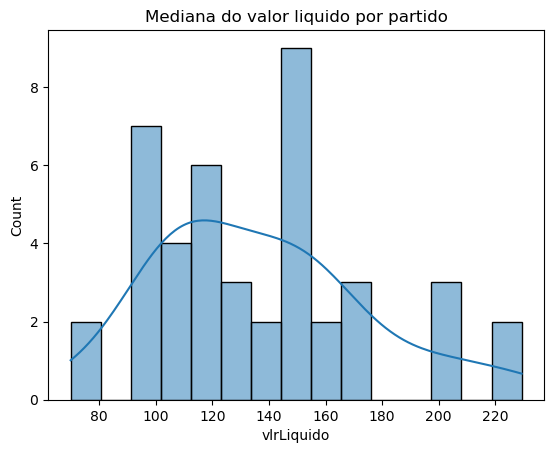

In [39]:
ax = sns.histplot(mediana_por_partido, bins=15, kde=True);
ax.set_title('Mediana do valor liquido por partido');

In [39]:
#Mediana do vlrLiquido por partido_por_palamentar
mediana_por_partido_por_palamentar = vlrLiquido_por_parlamentar_por_pat.median

mediana_por_partido_por_palamentar

<bound method Series.median of AVANTE            763.230349
CIDADANIA         721.232749
DEM               557.572896
MDB               751.013700
NOVO              383.800941
PATRI             554.948052
PATRIOTA         1083.767993
PCdoB             610.373287
PDT               669.345328
PEN               371.653594
PHS               720.698912
PL                947.269010
PMDB              484.621248
PMN               609.312042
PODE              687.544818
PP                751.978019
PP**              441.944646
PPL               840.253134
PPS               437.154794
PR                537.229647
PRB               747.671524
PRD              1039.502531
PROS              677.024921
PRP               962.926036
PRTB              625.335075
PSB               556.766731
PSC               613.920748
PSD               704.157774
PSDB              522.291322
PSDC              530.035763
PSL               624.800261
PSOL              635.721922
PT                548.116345
PTB         

### Medidas de dispersão

In [40]:
# Amlitude total geral
dataset_2['vlrLiquido'].max() - dataset_2['vlrLiquido'].min()

15792.4

In [40]:
# Amlitude total por estado
amplitude_por_estado = dataset_2.groupby('sgUF')['vlrLiquido'].max() - dataset_2.groupby('sgUF')['vlrLiquido'].min()

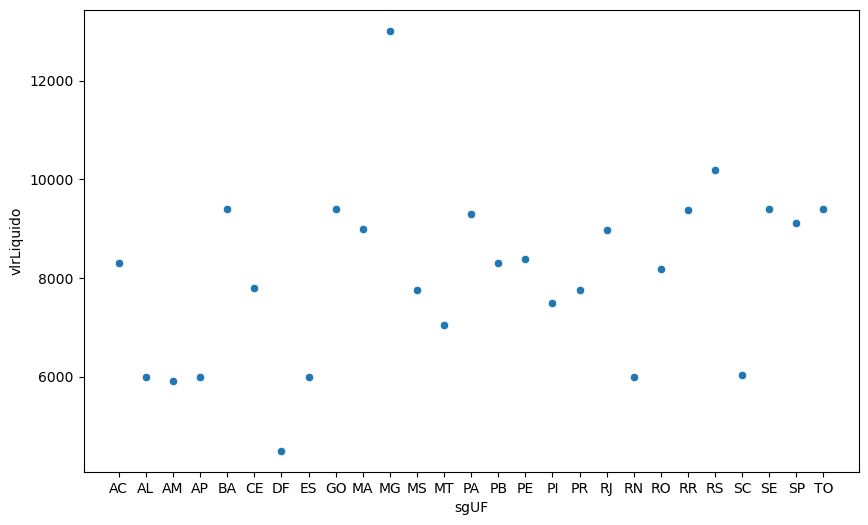

In [41]:
ax = sns.scatterplot(amplitude_por_estado)
ax.figure.set_size_inches(10, 6)
plt.show();

In [42]:
# Amplitude total por partido
amplitude_por_partido = dataset_2.groupby('sgPartido')['vlrLiquido'].max() - dataset_2.groupby('sgPartido')['vlrLiquido'].min()

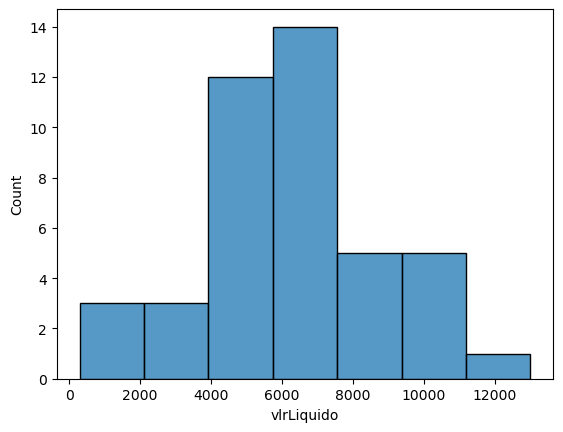

In [43]:
sns.histplot(amplitude_por_partido);

In [45]:
# Intervalo interquartílico geral
Q1 = dataset_2['vlrLiquido'].quantile(0.25)
Q3 = dataset_2['vlrLiquido'].quantile(0.75)
IQ = Q3-Q1
IQ

108.97

In [46]:
# Variância geral
dataset_2['vlrLiquido'].var()

371236.02613038354

In [44]:
# Variância por estado
var_estado = dataset_2.groupby('sgUF')['vlrLiquido'].var()

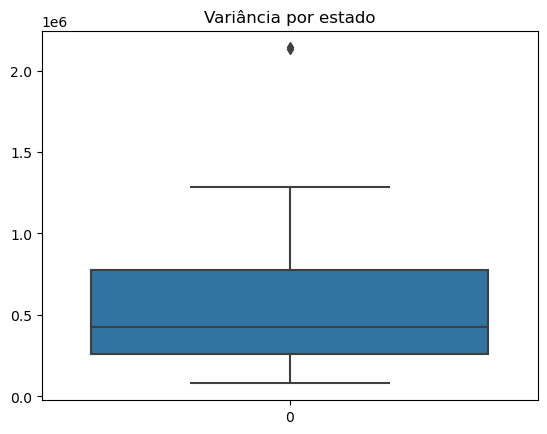

In [46]:
ax = sns.boxplot(var_estado)
ax.set_title('Variância por estado');

In [47]:
# Desvio padrão geral
dataset_2['vlrLiquido'].std()

609.3024212786921

### Medidas de Assimetria

In [50]:
#Calculando a assimetria da distribuição
valor_despesas = dataset_2['vlrLiquido']

dataset_assimetria = skew(valor_despesas)

print('Assimetria da distribuição: ', dataset_assimetria)

Assimetria da distribuição:  6.139503698940813


### Outliers

**Diagrama de Tukey (boxplot)**

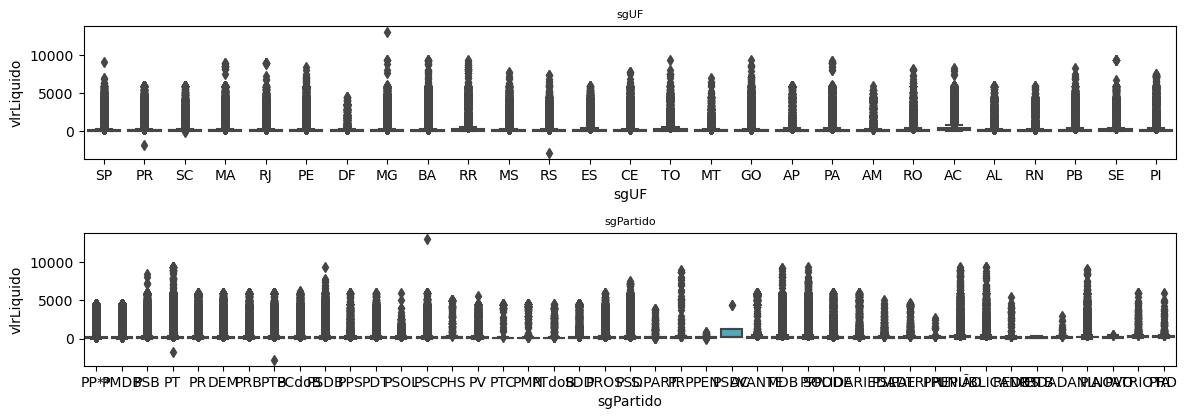

In [48]:
gridsize_boxplot = (4, 1)
fig_boxplot = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido']  

for i, position in enumerate(positions):
    boxplot = plt.subplot2grid(gridsize_boxplot, (i, 0))
    boxplot.set_title(position, fontsize=8)
    sns.boxplot(x=position, y='vlrLiquido', data=dataset_2)

plt.tight_layout()
plt.show();

**Gráfico de dispersão**

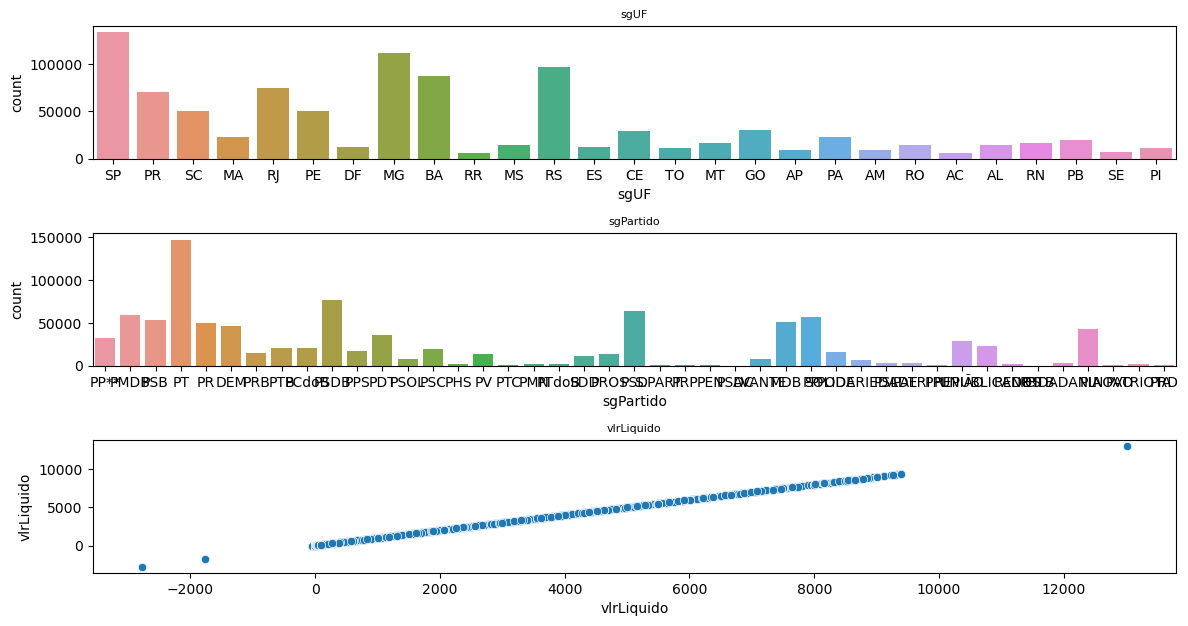

In [49]:
gridsize_scatter = (4, 1)
fig_scatter = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido', 'vlrLiquido']

for i, position in enumerate(positions):
    scatterplot = plt.subplot2grid(gridsize_scatter, (i, 0))
    scatterplot.set_title(position, fontsize=8)
    
    if dataset_2[position].dtype == 'object':
        sns.countplot(x=position, data=dataset_2, ax=scatterplot)
    else:
        sns.scatterplot(x=position, y='vlrLiquido', data=dataset_2, ax=scatterplot)

plt.tight_layout()
plt.show();

**Histograma**

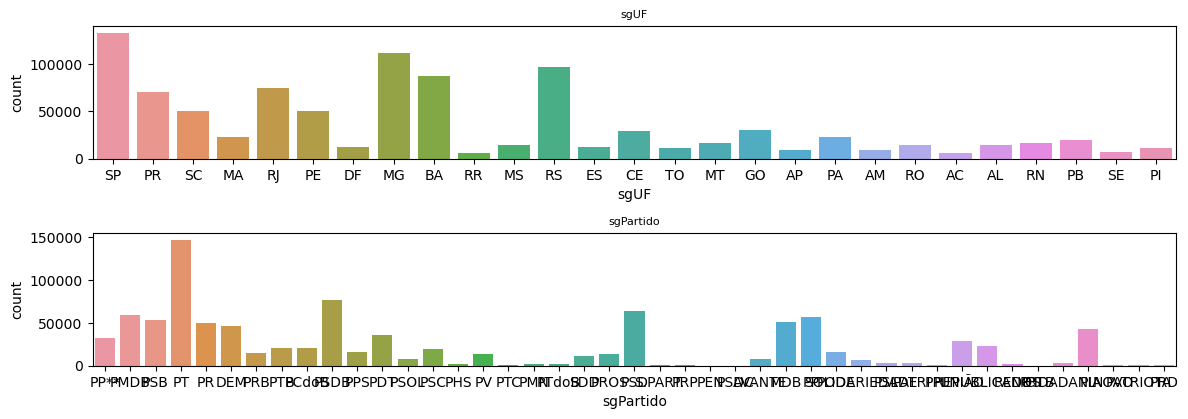

In [50]:
gridsize_barplot = (4, 1)
fig_barplot = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido']

for i, position in enumerate(positions):
    barplot = plt.subplot2grid(gridsize_barplot, (i, 0))
    barplot.set_title(position, fontsize=8)
    
    if dataset_2[position].dtype == 'object':
        sns.countplot(x=position, data=dataset_2, ax=barplot)
    else:
        sns.histplot(x=position, data=dataset_2, ax=barplot)

plt.tight_layout()
plt.show();

### Regressão Linear

In [51]:
dataset_2 = dataset_2.loc[:,['datEmissao', 'vlrLiquido']]

A regressão linear do sklearn não conseguiria usar diretamente a data, portanto foi necessária a conversão.

In [52]:
dataset_2['timestamp_unix'] = (dataset_2['datEmissao'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

Agora temos os segundos decorridos desde uma data base

In [53]:
#Parcionando dados
X = dataset_2[['timestamp_unix']]
y = dataset_2['vlrLiquido']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [54]:
# Criando modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [55]:
# Predição
predicted_values = model.predict(X_test)

In [56]:
# Análise da regressão
model.score(X_test,y_test)

0.0023456046190882818

<Axes: xlabel='datEmissao'>

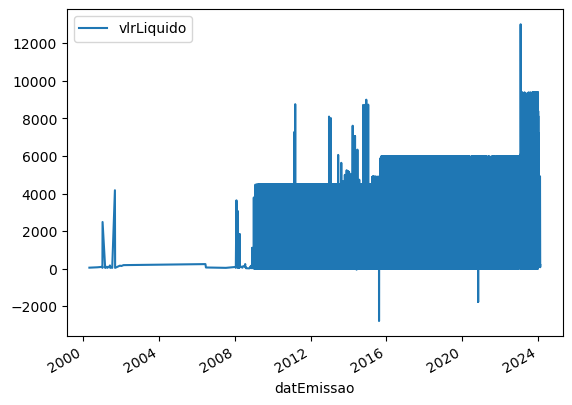

In [57]:
dataset_2.plot(y='vlrLiquido',x='datEmissao')

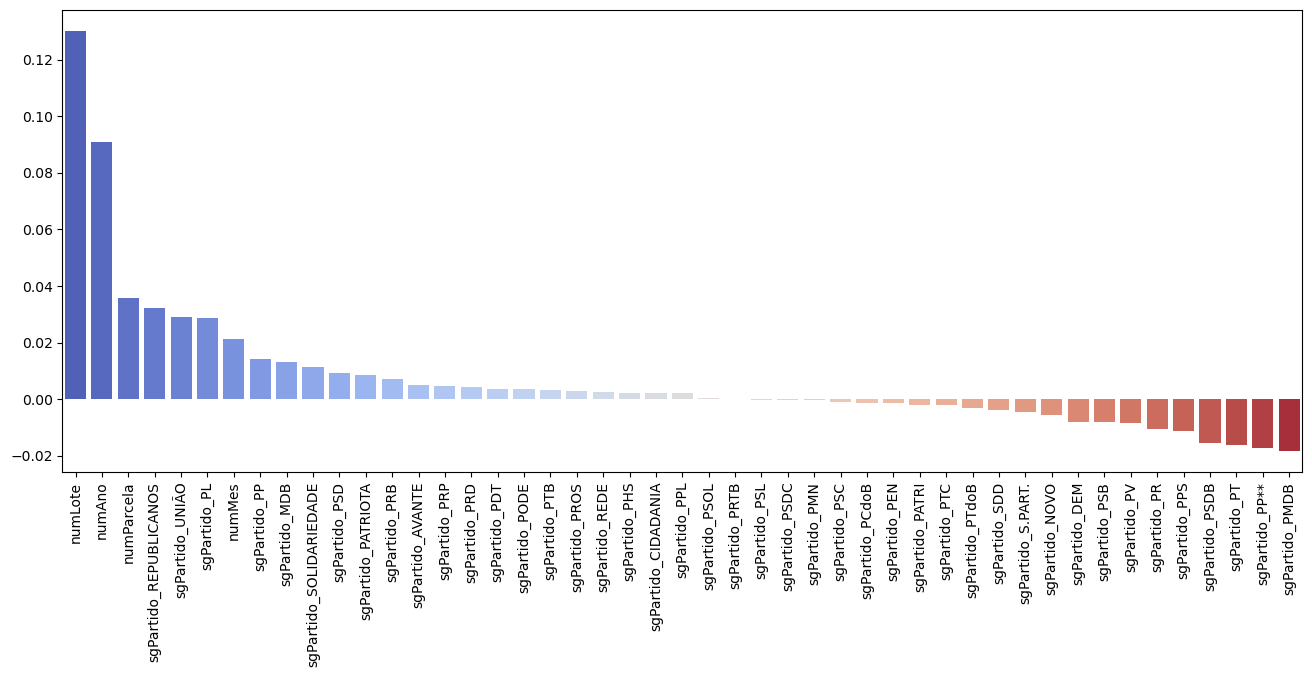

In [58]:
dummies = pd.get_dummies(despesas_completo[['numMes','sgPartido','numAno','numLote','vlrLiquido','numParcela']])
valores = dummies.corr()['vlrLiquido'].sort_values(ascending=False)[1:]

fig, ax = plt.subplots(figsize= (16, 6))
sns.barplot(x=valores.index, y=valores.values, palette='coolwarm')
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')

plt.show()

Não é possível encontrar relações lineares médias ou fortes ente valor líquido e as outras variáveis

In [59]:

X = pd.DataFrame(part_total)
y = vlrLiquido_por_partido
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [60]:
predicted_values = model.predict(X_test)

In [61]:
model.score(X_test,y_test)

0.9181861891795309

#### Probabilidade

In [62]:
#qual a probabilidade de um partido ter o gasto acima da média?

dataset_2 = despesas_completo[['ideCadastro','sgPartido', 'vlrLiquido']]

media_gastos = dataset_2['vlrLiquido'].mean()
partidos_acima_media = (dataset_2.groupby('sgPartido')['vlrLiquido'].mean() > media_gastos).sum()

num_total_partidos = len(dataset_2['sgPartido'].unique())

prob_gasto_part_acima_media = partidos_acima_media / num_total_partidos

print(prob_gasto_part_acima_media)

0.4772727272727273


In [63]:
#qual a probabilidade de um parlamentar ter um gasto acima da média?

media_gastos_parlamentar = dataset_2['vlrLiquido'].mean()
parlamentares_acima_media = (dataset_2.groupby('ideCadastro')['vlrLiquido'].mean() > media_gastos_parlamentar).sum()

num_total_parlamentares = len(dataset_2['ideCadastro'].unique())

prob_gasto_parlm_acima_media  = parlamentares_acima_media  / num_total_parlamentares

print(prob_gasto_parlm_acima_media)


0.5631517960602549
